code copied from 'Predicting Crypto Prices in Python' [https://youtu.be/GFSiL6zEZF0]

## import dependencies

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pandas_datareader as web
import datetime as dt

from yahoo_fin.stock_info import get_data

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM

## load data

In [2]:
crypto_currency = 'ETH'
against_currency = 'USD'

start = dt.datetime(2018,6, 1)
end = dt.datetime.now()

data = get_data(f'{crypto_currency}-{against_currency}', start, end)

In [3]:
data

,open,high,low,close,adjclose,volume,ticker
2018-05-31,578.671997,589.093018,567.664978,580.043030,580.043030,1.945890e+09,ETH-USD
2018-06-01,580.429016,597.077026,577.322021,591.807983,591.807983,1.880390e+09,ETH-USD
2018-06-02,591.258972,624.513000,591.258972,618.328979,618.328979,1.832550e+09,ETH-USD
2018-06-03,619.437012,623.429016,583.747009,592.984985,592.984985,1.903430e+09,ETH-USD
2018-06-04,593.406006,611.330017,580.981995,609.302979,609.302979,1.844270e+09,ETH-USD
...,...,...,...,...,...,...,...
2021-08-10,3142.830322,3269.209473,3122.916504,3164.245117,3164.245117,2.672904e+10,ETH-USD
2021-08-11,3164.175781,3236.314697,2984.166992,3043.414307,3043.414307,2.540370e+10,ETH-USD
2021-08-12,3049.001221,3324.671631,3037.676025,3322.211670,3322.211670,2.386887e+10,ETH-USD
2021-08-13,3322.762695,3329.281006,3214.519775,3265.443359,3265.443359,1.986086e+10,ETH-USD


## Prepare Data

In [4]:
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(data['close'].values.reshape(-1,1))

prediction_days = 60
future_day = 30

x_train, y_train = [], []

for x in range(prediction_days, len(scaled_data)-future_day):
    x_train.append(scaled_data[x-prediction_days:x, 0])
    y_train.append(scaled_data[x+future_day, 0])
    
x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

## Create Neural Network

In [5]:
model = Sequential()

model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1],1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1))

model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(x_train, y_train, epochs=25, batch_size=32)

Epoch 1/25
34/34 [==============================] - 15s 101ms/step - loss: nan
Epoch 2/25
34/34 [==============================] - 3s 103ms/step - loss: nan
Epoch 3/25
34/34 [==============================] - 4s 110ms/step - loss: nan
Epoch 4/25
34/34 [==============================] - 4s 105ms/step - loss: nan
Epoch 5/25
34/34 [==============================] - 4s 115ms/step - loss: nan
Epoch 6/25
34/34 [==============================] - 4s 104ms/step - loss: nan
Epoch 7/25
34/34 [==============================] - 4s 104ms/step - loss: nan
Epoch 8/25
34/34 [==============================] - 4s 112ms/step - loss: nan
Epoch 9/25
34/34 [==============================] - 4s 111ms/step - loss: nan
Epoch 10/25
34/34 [==============================] - 4s 108ms/step - loss: nan
Epoch 11/25
34/34 [==============================] - 3s 102ms/step - loss: nan
Epoch 12/25
34/34 [==============================] - 4s 104ms/step - loss: nan
Epoch 13/25
34/34 [==============================] - 4s 106m

## Testing the model

In [13]:
test_start = dt.datetime(2020,6, 1)
test_end = dt.datetime.now()

test_data = get_data(f'{crypto_currency}-{against_currency}', start, end)
actual_prices = test_data['close'].values

total_dataset = pd.concat((data['close'], test_data['close']), axis=0)

model_inputs = total_dataset[len(total_dataset)-len(test_data)-prediction_days:].values
model_inputs = model_inputs.reshape(-1,1)
model_inputs = scaler.fit_transform(model_inputs)

In [14]:
x_test = []

for x in range(prediction_days, len(model_inputs)):
    x_test.append(model_inputs[x-prediction_days:x, 0])

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

prediction_prices = model.predict(x_test)
prediction_prices = scaler.inverse_transform(prediction_prices)

## Plot test data

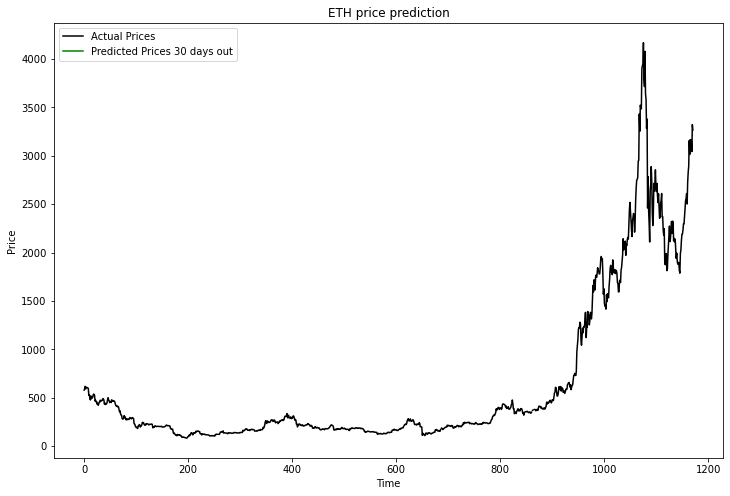

In [15]:
plt.figure(figsize=(12,8))
plt.plot(actual_prices, color="black", label='Actual Prices')
plt.plot(prediction_prices, color="green", label='Predicted Prices 30 days out')
plt.title(f'{crypto_currency} price prediction')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend(loc='upper left')
plt.show()

## Predict next day

In [16]:
real_data = [model_inputs[len(model_inputs)-prediction_days:len(model_inputs)+1, 0]]
real_data = np.array(real_data)
real_data = np.reshape(real_data, (real_data.shape[0], real_data.shape[1], 1))

prediction = model.predict(real_data)
prediction = scaler.inverse_transform(prediction)
print(f"Prediction: {prediction}")

Prediction: [[nan]]
